In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage

In [2]:
all_tracks = pickle.load(open('all_tracks.pkl'))


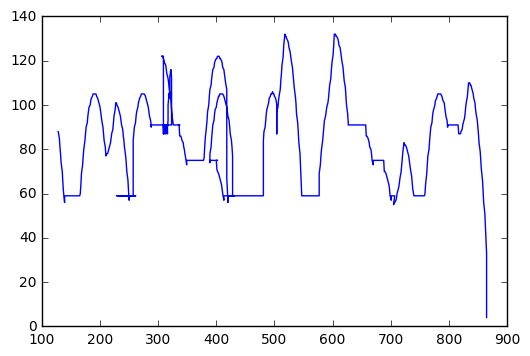

In [3]:
for track in all_tracks:
    if track[0] == 'track1':
        dat  = [track[1][t][0] for t in sorted(track[1])]
        break
        
dat = np.array(dat)
plt.plot(dat[:,0],dat[:,1])
plt.show()

In [4]:
def overlaps(box1,box2,offset=1):
    
    if (box1[2] <= box2[3]+offset and
        box1[3]+offset >= box2[2] and
        box1[4] <= box2[5]+offset and
        box1[5]+offset >= box2[4]):
        diff = np.array(box2[0:2])-np.array(box1[0:2])
        if np.abs(diff[0]) > np.abs(diff[1]):
            if diff[0] > 0:
                return 'left'
            else:
                return 'right'
        else:
            if diff[1] > 0:
                return 'top'
            else:
                return 'bottom'
        
        
    else:
        return None
 

In [5]:
collisions = {}
(animation_at_time,animation_indices,groups) = pickle.load(open('animation_at_time.pkl','rb'))
(tile_animation_at_time,tile_animation_indices,tile_groups) = pickle.load(open('tile_animation_at_time.pkl','rb'))
ind2anim = {}
for a in animation_indices:
    ind2anim[animation_indices[a]] = a

In [6]:
tile_changes = pickle.load(open('tile_changes.pkl'))
change_at_time = {}

for change in tile_changes:
    for t in tile_changes[change]:
        if t not in change_at_time:
            change_at_time[t] = set()
        change_at_time[t].add(change)

In [7]:
track2group = {}
for g in groups:
    for t in groups[g]:
        track2group[t] = g

tile2group = {}   
for g in tile_groups:
    for t in tile_groups[g]:
        tile2group[t] = g

collisions = {}  
start_time_out = 0
for track_id,track in enumerate(all_tracks):
    times = sorted(track[1])
    start = times[0]
    for other_id,other in enumerate(all_tracks):
        #print track[0],other[0]
        other_times = sorted(other[1])
        if track_id < other_id:
            other_times = sorted(other[1])
            track_collisions = {}
            last_collision = -1
            other_start = other_times[0]
            for t in times[start_time_out:]:
                
                if t in other_times and t > other_start+start_time_out:
                    blob1 = animation_at_time[track[0]][t]
                    blob2 =  animation_at_time[other[0]][t]

                    collision = -1
                    sprite_box = track[1][t][1]
                    other_box = other[1][t][1]
                    
                    collision =  overlaps(sprite_box,other_box)
                    if collision:
                        if t not in collisions:
                            collisions[t] = []
                        if True:#t-last_collision > 1:
                            #collisions[t].append((t,blob1,blob2))
                            collisions[t].append((t-start,t-other_start,collision,blob1,blob2))
                            collisions[t].append((t-start,t-other_start,collision,track2group[track[0]],blob2))
                            collisions[t].append((t-start,t-other_start,collision,blob1,track2group[other[0]]))
                            collisions[t].append((t-start,t-other_start,collision,track2group[track[0]],track2group[other[0]]))
                            track_collisions[t] = collision
                        else:
                            print 'skipped'
                        last_collision  = t

In [8]:
import re
for location in  tile_animation_at_time: 
    times = sorted(tile_animation_at_time[location])
    start = times[0]
    bounding_box = [location[1]*8+4,(location[0]*8+32+4),location[1]*8,location[1]*8+8,(location[0]*8+32),(location[0]*8+8+32)]
    # if 160 in times and tile2group[location] != (16, 109):
    #     print location,bounding_box,tile2group[location]
    # continue
    for other_id,other in enumerate(all_tracks):
        track_collisions = {}
        last_collision = -1
        
        other_times = sorted(other[1])
        other_start = other_times[0]
        for t in times[start_time_out:]:
            
            if t in other_times  and t > other_start+start_time_out and t in tile_animation_at_time[location]:
                blob = ('tile', tile_animation_at_time[location][t])
                collision = -1

                blob2 =  animation_at_time[other[0]][t]
           
                other_box = other[1][t][1]
                collision =  overlaps(bounding_box,other_box)
                if collision:
                    if t not in collisions:
                        collisions[t] = []
                    if True:#t-last_collision > 1:
                        collisions[t].append((t-start,t-other_start,collision,blob,blob2))
                        collisions[t].append((t-start,t-other_start,collision,('tilegroup',tile2group[location]),blob2))
                        collisions[t].append((t-start,t-other_start,collision,blob,track2group[other[0]]))
                        
                        collisions[t].append((t-start,t-other_start,collision,('tilegroup',tile2group[location]),track2group[other[0]]))
                        track_collisions[t] = collision
                    last_collision  = t

In [9]:

collision_starts = {}

for t in sorted(collisions):
    if t not in collision_starts:
        collision_starts[t] = set()
    for collision in collisions[t]:
        collision_starts[t].add(collision)
    

In [10]:
n = 20
last_n = [[]]*n
collision_starts = {}
timeout = 15
for t in sorted(collisions):
    non_directional = [collision[3:] for collision in collisions[t]]
    for nd_collision, collision in zip(non_directional,collisions[t]):
        not_in_all = True
        for last in last_n:
            if nd_collision in last:
                not_in_all = False
                break
        if not_in_all:
            if t not in collision_starts:
                collision_starts[t] = set()
            if collision[0] > timeout and collision[1] > timeout:
                collision_starts[t].add(collision[2:])
    last_n.pop(0)
    last_n.append(non_directional)



In [11]:

events = {}
counts = {}
timesteps = 0.0
cocounts = {}
additional = 4
seen = set()
for t in collisions:
    timesteps += 1.0
    
    for coll in collision_starts.get(t,[]):
        coll = coll[1:]
        if coll not in counts:
            counts[coll] = 0.
        counts[coll] += 1
        for t_ in range(t,t+additional):
            
            if t_ in change_at_time:
                for change in change_at_time[t_]:
                        
                    if change not in cocounts:
                        cocounts[change] = {}
                    if coll not in cocounts[change]:
                        cocounts[change][coll] = 0.
                    if (t_,change,coll) not in seen:
                        cocounts[change][coll] += 1.
                    seen.add((t_,change,coll))

                    

In [12]:
causes = {}
thresh = 0.7
for change in sorted(tile_changes):
    is_found = False
    for f in ind2anim[change[0]]:
        is_found = is_found or f in  ind2anim[change[1]]
    if is_found:
        continue
    print change,sorted(tile_changes[change])
    
    
    print ind2anim[change[0]], '->', ind2anim[change[1]]
    p1 = float(len(tile_changes[change]))/timesteps
    causes = {(True,True):[0,[]],
              (True,False):[0,[]],
              (False,True):[0,[]],
              (False,False):[0,[]]}
    if change in cocounts:
        highest = 0
        best = []
        for co in cocounts[change]:
            p2 = counts[co]/timesteps
            p12 = cocounts[change][co]/timesteps
            pmi = np.log(p12/(p1*p2))
            npmi = -pmi/np.log(p12)
            generic_tile = type(co[0]) is tuple and 'tilegroup' in co[0]
            generic_sprite = type(co[1]) is str 
            if p1 > 3*p2:
                continue
            if npmi >= causes[generic_tile,generic_sprite][0]:
                if npmi != causes[generic_tile,generic_sprite][0]:
                    causes[generic_tile,generic_sprite][0] = npmi
                    causes[generic_tile,generic_sprite][1] = []
                causes[generic_tile,generic_sprite][1].append((change,co, npmi,p1,p2,p12,pmi))
        if len(causes[True,True][1]) > 0 and causes[True,True][0] > thresh:
            print causes[True,True]
        elif len(causes[True,False][1]) > 0 and causes[True,False][0] > thresh:
            print causes[True,False]
        elif len(causes[False,True][1]) > 0 and causes[False,True][0] > thresh:
            print causes[False,True]
        elif  causes[False,False][0] > thresh:
            print causes[False,False]
        
            
    print ''
    
    

(0, 1) [920]
(11,) -> (2,)
[1.0, [((0, 1), (('tilegroup', (22, 109)), 'track1'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 1), (('tilegroup', (23, 34)), 'track1'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 1), (('tilegroup', (24, 65)), 'track1'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 1), (('tilegroup', (28, 49)), 'track1'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 1), (('tilegroup', (28, 34)), 'track1'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 1), (('tilegroup', (29, 118)), 'track1'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 1), (('tilegroup', (22, 98)), 'track1'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539)

KeyError: 54

In [13]:
sprite_changes = pickle.load(open('sprite_changes.pkl'))
change_at_time = {}

for change in sprite_changes:
    for t in sprite_changes[change]:
        if t not in change_at_time:
            change_at_time[t] = set()
        change_at_time[t].add(change)
for track in all_tracks:
    times = sorted(track[1])
    
    if times[0] not in change_at_time:
        change_at_time[times[0]] = set()
    
    if times[-1] not in change_at_time:
        change_at_time[times[-1]] = set()
    change_at_time[times[0]].add(('start',track2group[track[0]]))
    change_at_time[times[-1]].add(('end',track2group[track[0]]))
    if ('start',track2group[track[0]]) not in sprite_changes:
        sprite_changes[('start',track2group[track[0]])] = []
    sprite_changes[('start',track2group[track[0]])].append(times[0])
    if ('end',track2group[track[0]]) not in sprite_changes:
        sprite_changes[('end',track2group[track[0]])] = []
    sprite_changes[('end',track2group[track[0]])].append(times[-1])

In [14]:

events = {}
counts = {}
timesteps = 0.0
cocounts = {}
additional = 10
seen = set()
for t in collisions:
    timesteps += 1.0
    
    for coll in collision_starts.get(t,[]):
        coll = coll[1:]
        if coll not in counts:
            counts[coll] = 0.
        counts[coll] += 1
        for t_ in range(t,t+additional):
            
            if t_ in change_at_time:
                for change in change_at_time[t_]:
                        
                    if change not in cocounts:
                        cocounts[change] = {}
                    if coll not in cocounts[change]:
                        cocounts[change][coll] = 0.
                    if (t_,change,coll) not in seen:
                        cocounts[change][coll] += 1.
                    seen.add((t_,change,coll))


In [15]:
causes = {}
for change in sorted(sprite_changes):
    is_found = False
    if change[0] not in ['start','end']:
        for f in ind2anim[change[0]]:
            is_found = is_found or f in  ind2anim[change[1]]
        if is_found:
            continue
    print change,sprite_changes[change]
    
    
    p1 = float(len(sprite_changes[change]))/timesteps
    causes = {(True,True):[0,[]],
              (True,False):[0,[]],
              (False,True):[0,[]],
              (False,False):[0,[]]}
    if change in cocounts:
        highest = 0
        best = []
        for co in cocounts[change]:
            p2 = counts[co]/timesteps
            p12 = cocounts[change][co]/timesteps
            pmi = np.log(p12/(p1*p2))
            npmi = -pmi/np.log(p12)
            generic_tile = (type(co[0]) is tuple and 'tilegroup' in co[0]) or  type(co[1]) is str 
            generic_sprite = type(co[1]) is str 
            
            if npmi >= causes[generic_tile,generic_sprite][0]:
                if npmi != causes[generic_tile,generic_sprite][0]:
                    causes[generic_tile,generic_sprite][0] = npmi
                    causes[generic_tile,generic_sprite][1] = []
                causes[generic_tile,generic_sprite][1].append((change,co, npmi,p1,p2,p12,pmi))
        if len(causes[True,True][1]) > 0:
            print causes[True,True]
        elif len(causes[True,False][1]) > 0:
            print causes[True,False]
        elif len(causes[False,True][1]) > 0:
            print causes[False,True]
        else:
            print causes[False,False]
        
            
    print ''

(0, 1) [851, 164, 396, 677]
[0.92655230226436824, [((0, 1), (36, 'track38'), 0.92655230226436824, 0.004004004004004004, 0.006006006006006006, 0.004004004004004004, 5.1149953094204985)]]

(0, 4) [752]
[1.0, [((0, 4), (3, 'track28'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 4), (4, 'track3'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 4), (37, 'track8'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539), ((0, 4), (4, 'track8'), 1.0, 0.001001001001001001, 0.001001001001001001, 0.001001001001001001, 6.9067547786485539)]]

(0, 5) [668, 669]
[1.1115530985209248, [((0, 5), ('track28', 'track28'), 1.1115530985209248, 0.002002002002002002, 0.001001001001001001, 0.002002002002002002, 6.9067547786485539), ((0, 5), (30, 'track8'), 1.1115530985209248, 0.002002002002002002, 0.001001001001001001, 0.002002002002002002, 6.9067547786485539), ((0, 5), (0, 

SyntaxError: unexpected EOF while parsing (<ipython-input-16-4ff4d2ab137f>, line 1)

In [ ]:
track2group = {}
for g in groups:
    for t in groups[g]:
        track2group[t] = g

tile2group = {}   
for g in tile_groups:
    for t in tile_groups[g]:
        tile2group[t] = g

collisions = {}  
start_time_out = 5
for track_id,track in enumerate(all_tracks):
    times = sorted(track[1])
    if track[0] != 'track1':
        continue
    for other_id,other in enumerate(all_tracks):
        print track[0],other[0]
        other_times = sorted(other[1])
        if track_id < other_id:
            other_times = sorted(other[1])
            track_collisions = {}
            last_collision = -1
            other_start = other_times[0]
            for t in times[start_time_out:]:
                
                if t in other_times and t > other_start+start_time_out:
                    blob1 = animation_at_time[track[0]][t]
                    blob2 =  animation_at_time[other[0]][t]

                    collision = -1
                    sprite_box = track[1][t][1]
                    other_box = other[1][t][1]
                    collision =  overlaps(sprite_box,other_box)
                    if collision >= 0:
                        if t not in collisions:
                            collisions[t] = []
                        if True:#t-last_collision > 1:
                            collisions[t].append((('sprite',blob1),('sprite', blob2)))
                            collisions[t].append((track2group[track[0]],track2group[other[0]]))
                            track_collisions[t] = collision
                        else:
                            print 'skipped'
                        last_collision  = t
pickle.dump(collisions,open('sprite_collisions.pkl','wb'))
                                                 
collisions = {}                        
for track_id,track in enumerate(tile_tracks[:]): 
    times = sorted(track[1])
    match = re.match('tile(\d+),(\d+)',track[0])
    y = int(match.group(1))
    x = int(match.group(2))
    location = (y,x)
    for other_id,other in enumerate(all_tracks):
        if other[0] != 'track1':
            continue
        track_collisions = {}
        last_collision = -1
        other_times = sorted(other[1])
        other_start = other_times[0]
        for t in times[start_time_out:]:
            
            if t in other_times  and t > other_start+start_time_out and t in tile_animation_at_time[location]:
                blob = ('tile', tile_animation_at_time[location][t])
                collision = -1

                blob2 =  animation_at_time[other[0]][t]

                
                bounding_box = track[1][t][1]
                other_box = other[1][t][1]
                collision =  overlaps(bounding_box,other_box)

                if collision >= 0:
                    if t == 9 and blob == ('tile',52):
                        print location
                    if t not in collisions:
                        collisions[t] = []
                    if True:#t-last_collision > 1:
                        collisions[t].append((('tile',blob),('sprite',blob2)))
                        collisions[t].append((('tilegroup',tile2group[location]),track2group[other[0]]))
                        track_collisions[t] = collision
                    last_collision  = t
pickle.dump(collisions,open('tile_collisions.pkl','wb'))

In [ ]:
for t in sorted(collision_starts):
    for coll in collision_starts[t]:
        if 'track1' in coll and 'track53' in coll:
            print t,coll